## This notebook is my *from scratch* version of the 90% of NLP Problems workshop

[Article](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)

[Github](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb)

In [2]:
# Import libraries
import pandas as pd
import io
import re
## import nltk  ## maybe import whole package later
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import collections


/home/topquirk67/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
[nltk_data] Downloading package punkt to /home/topquirk67/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/topquirk67/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Get the data... I just stole their code because I'm not quite sure what they need to do here
# or if the data file I fetched is correct!
input_file = io.open("socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [4]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head(5)

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [5]:
# A little EDA
import seaborn as sns
print(questions.class_label.value_counts())
print(questions.choose_one.value_counts())
questions[questions.isna().any(axis=1)]


0    6163
1    4635
2      16
Name: class_label, dtype: int64
Not Relevant    6163
Relevant        4635
Can't Decide      16
Name: choose_one, dtype: int64


,text,choose_one,class_label


So it seems that the classes are pretty close to balanced, and class_label is just encoded with relevant = 1; not = 0.

In [6]:
# Verify that data is encoded exactly correctly
pd.crosstab(questions.choose_one,questions.class_label)

class_label,0,1,2
choose_one,,,
Can't Decide,0,0,16
Not Relevant,6163,0,0
Relevant,0,4635,0


### Process words:
- Remove non-alphabetical characters
- lowercase



In [7]:

# Here we just use the definitions given by Ameisen
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")   
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")
# questions.to_csv("clean_data.csv")  # maybe use this later??? 
# questions.head()

In [8]:
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


Tokenize!

In [9]:
# example tokenize
sentence = questions.text[174]
tokens = nltk.word_tokenize(sentence)

In [10]:
tokens

['aftershock',
 'protect',
 'yourself',
 'and',
 'profit',
 'in',
 'the',
 'next',
 'global',
 'financial',
 'meltdown',
 'by',
 'david',
 'wiedemer']

In [11]:
# tokenize and examine the whole data frame
# NB this differs from the example, so if you re-do this, check back there 
# for alternate ways to do it
questions['tokens']=questions['text'].apply(nltk.word_tokenize)
questions.tokens.head()

0            [just, happened, a, terrible, car, crash]
1    [our, deeds, are, the, reason, of, this, earth...
2    [heard, about, earthquake, is, different, citi...
3    [there, is, a, forest, fire, at, spot, pond, ,...
4        [forest, fire, near, la, ronge, sask, canada]
Name: tokens, dtype: object

In [12]:
# Stemming... others to try: SnowBall, Lancaster
stemmer = PorterStemmer()

In [13]:
## Just an example of doing stemming:
# plurals = ['caresses', 'flies', 'dies', 'mules', 'denied',
# ...            'died', 'agreed', 'owned', 'humbled', 'sized',
# ...            'meeting', 'stating', 'siezing', 'itemization',
# ...            'sensational', 'traditional', 'reference', 'colonizer',
# ...            'plotted']

# singles = [stemmer.stem(plural) for plural in plurals]

# print(' '.join(singles))  


In [14]:
# Produce stemmed column
questions['stems'] = [[stemmer.stem(item) for item in row] for row in questions['tokens']]

In [15]:
# can't find a pythonic way to do this!
# but look for a non-stemmed word and see if it's present.
s = 'fire'
for index, row in questions.iterrows():
    if (s in row.stems):
        print(index, row['stems'])

3 ['there', 'is', 'a', 'forest', 'fire', 'at', 'spot', 'pond', ',', 'gees', 'are', 'flee', 'across', 'the', 'street', ',', 'i', 'can', 'not', 'save', 'them', 'all']
4 ['forest', 'fire', 'near', 'la', 'rong', 'sask', 'canada']
8 ['rockyfir', 'updat', 'california', 'hwi', '20', 'close', 'in', 'both', 'direct', 'due', 'to', 'lake', 'counti', 'fire', 'cafir', 'wildfir']
13 ['i', "'m", 'on', 'top', 'of', 'the', 'hill', 'and', 'i', 'can', 'see', 'a', 'fire', 'in', 'the', 'wood']
46 ['birmingham', 'wholesal', 'market', 'is', 'ablaz', 'bbc', 'news', 'fire', 'break', 'out', 'at', 'birmingham', "'s", 'wholesal', 'market']
91 ['steve', 'these', 'fire', 'out', 'here', 'are', 'someth', 'els', '!', 'california', 'is', 'a', 'tinderbox', 'and', 'thi', 'clown', 'wa', 'set', 'my', "'hood", 'ablaz']
93 ['huge', 'fire', 'at', 'wholesal', 'market', 'ablaz']
547 ['cheesehead', 'report', 'arson', 'charg', 'file', 'in', 'jackson', 'counti', 'hous', 'fire']
548 ['arson', 'suspect', 'link', 'to', '30', 'fire', 

4050 ['crew', 'were', 'out', 'all', 'day', 'board', 'up', 'window', 'at', 'the', 'park', 'at', 'the', 'galleria', 'apt', 'where', 'fire', 'displac', '55', 'thi', 'am']
4057 ['kca', 'votejkt48id', '12new', 'updat', 'a', 'famili', 'of', '3', 'ha', 'been', 'displac', 'after', 'fire', 'damag', 'hous', 'near', '90th', 'and', 'osborn', 'fire', 'extinguish', 'no', 'i', '_']
4064 ['kca', 'votejkt48id', '12new', 'updat', 'a', 'famili', 'of', '3', 'ha', 'been', 'displac', 'after', 'fire', 'damag', 'hous', 'near', '90th', 'and', 'osborn', 'fire', 'extinguish', 'no', 'i', '_']
4075 ['local', 'famili', 'displac', 'by', 'fire', 'via', 'let', 'help', 'that', 'famili', 'out', 'pleas']
4087 ['40', 'displac', 'by', 'ocean', 'township', 'apart', 'fire', 'newyork']
4088 ['pennliv', 'two', 'famili', 'displac', 'by', 'mechanicsburg', 'blaze', 'no', 'one', 'wa', 'injur', 'in', 'the', 'fire']
4089 ['a', 'crime', 'that', 'kill', 'displac', 'million', 'in', 'which', 'systemat', 'tortur', 'wa', 'carri', 'out', '

8798 ['so', 'far', 'miss', 'may', 'i', 'sleep', 'with', 'siren', 'august', 'burn', 'red', 'memphi', 'may', 'fire', 'attila', 'amp', 'all', 'were', 'so', 'good', '?', '?']
8818 ['i', 'wa', 'walk', 'past', 'the', 'fire', 'hous', 'today', 'amp', 'as', 'soon', 'as', 'i', 'walk', 'by', 'the', 'door', 'they', 'get', 'call', 'and', 'flip', 'the', 'siren', 'on', 'i', "'ve", 'never', 'ran', 'so', 'fast']
8833 ['fire', 'truck', 'siren', 'for', 'the', 'past', 'ten', 'minut', 'straight', 'come', 'and', 'go', 'must', 'be', 'huge', 'mayb', 'it', "'s", 'taco', 'bell', 'and', 'they', "'ll", 'build', 'a', 'sonic', 'instead']
8849 ['smoke', '?', '?', 'so', 'much', 'you', 'do', "n't", 'got', 'ta', 'do', 'shit', 'but', 'light', '?', '?', 'one', 'of', 'hi', 'lock', 'on', 'fire', 'that', "'s", 'like', 'a', 'whole', 'tre', 'five', 'right', 'there']
8872 ['sky', 'look', 'clear', 'no', 'smoke', 'from', 'the', 'fire', 'enjoy', 'your', 'time', 'in', 'taho', 'one', 'of', 'my', 'favorit', 'place', '!']
8900 ['sorr

In [16]:
# Try Lemmatizing as a separate column
wordnet_lemmatizer = WordNetLemmatizer()
questions['lemma'] =  [[wordnet_lemmatizer.lemmatize(item) for item in row] for row in questions['tokens']]

We will just keep parallel paths of lemmatization and stemming and see which leads to better results.

In [17]:
# Some more exploration... how many words in the vocabulary?
# Create vectors from vocabulary
stem_vocab = collections.Counter()
for item in questions.stems:
    stem_vocab.update(item)
lemm_vocab = collections.Counter()
for item in questions.lemma:
    lemm_vocab.update(item)

print('==========================\nStemmed data:')
print('Total number of stems/words:     ',sum(stem_vocab.values()))
print('Total unique stems/words:        ',len(stem_vocab))
print('Most common words in the lextcon:\n',stem_vocab.most_common(100))
print('==========================\nLemmatized data:')
print('Total number of stems/words:     ',sum(lemm_vocab.values()))
print('Total unique stems/words:        ',len(lemm_vocab))
print('Most common words in the lextcon:\n',lemm_vocab.most_common(100))


Stemmed data:
Total number of stems/words:      162142
Total unique stems/words:         14726
Most common words in the lextcon:
 [('the', 4552), ('?', 4404), ('a', 3093), ('to', 2830), ('in', 2793), ('of', 2597), ('i', 2500), ('and', 2013), ('!', 1647), ('is', 1413), ('you', 1274), ('for', 1238), ('on', 1234), ('it', 1219), ("'s", 1091), ("'", 1043), ('my', 969), ('that', 851), ('with', 797), ('at', 790), ('by', 772), ('be', 715), ('thi', 706), ("n't", 620), ('are', 619), ('from', 611), ('like', 590), ('wa', 581), ('have', 563), ('_', 532), ('fire', 529), ('do', 516), (')', 512), ('amp', 509), ('(', 503), ('as', 484), ('up', 464), ('your', 461), ('just', 453), ('get', 451), ('me', 450), ('not', 444), ('but', 434), ('so', 428), ('we', 412), ('out', 412), ('no', 399), ('will', 378), ('all', 366), ('ha', 366), ('after', 365), ('when', 359), ("'m", 351), ('he', 351), ('an', 349), ('if', 344), ('bomb', 331), ('new', 329), ('they', 325), ('via', 324), ('more', 322), ('about', 313), ('2', 31

Yak... what's an embedding, what do these actually look like etc.? 

In [31]:
questions.head()
# compile the 'stems' and 'tokens' columns back into strings for input into a corpus
# questions['s_stem'] = ' '.join(questions.stems)
# questions['tokens']=questions['text'].apply(nltk.word_tokenize)
questions['s_stems'] =  [' '.join(row) for row in questions['stems']]
questions['s_lemmas'] =  [' '.join(row) for row in questions['lemma']]

In [37]:
# Need to split training and test set before we do TFIDF since it's extracted from the samples themselves.
# Gak, I just stole this code directly.   
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

#list_corpus = questions['text'].tolist()
#list_corpus = questions['s_stems'].tolist()
list_corpus = questions['s_lemmas'].tolist()
list_labels = questions['class_label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [38]:
questions.head()

,text,choose_one,class_label,tokens,stems,lemma,s_stems,s_lemmas
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]","[just, happen, a, terribl, car, crash]","[just, happened, a, terrible, car, crash]",just happen a terribl car crash,just happened a terrible car crash
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth...","[our, deed, are, the, reason, of, thi, earthqu...","[our, deed, are, the, reason, of, this, earthq...",our deed are the reason of thi earthquak may a...,our deed are the reason of this earthquake may...
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi...","[heard, about, earthquak, is, differ, citi, ,,...","[heard, about, earthquake, is, different, city...","heard about earthquak is differ citi , stay sa...","heard about earthquake is different city , sta..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, ,...","[there, is, a, forest, fire, at, spot, pond, ,...","[there, is, a, forest, fire, at, spot, pond, ,...","there is a forest fire at spot pond , gees are...","there is a forest fire at spot pond , goose ar..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la rong sask canada,forest fire near la ronge sask canada


In [39]:
# just playing with a sparse matrix

for row in range(200):
    if (X_train_counts[row,:].max())>2:
        print (row,X_train_counts[row,:].max())



22 3
65 4
109 3
142 4
181 3
188 3


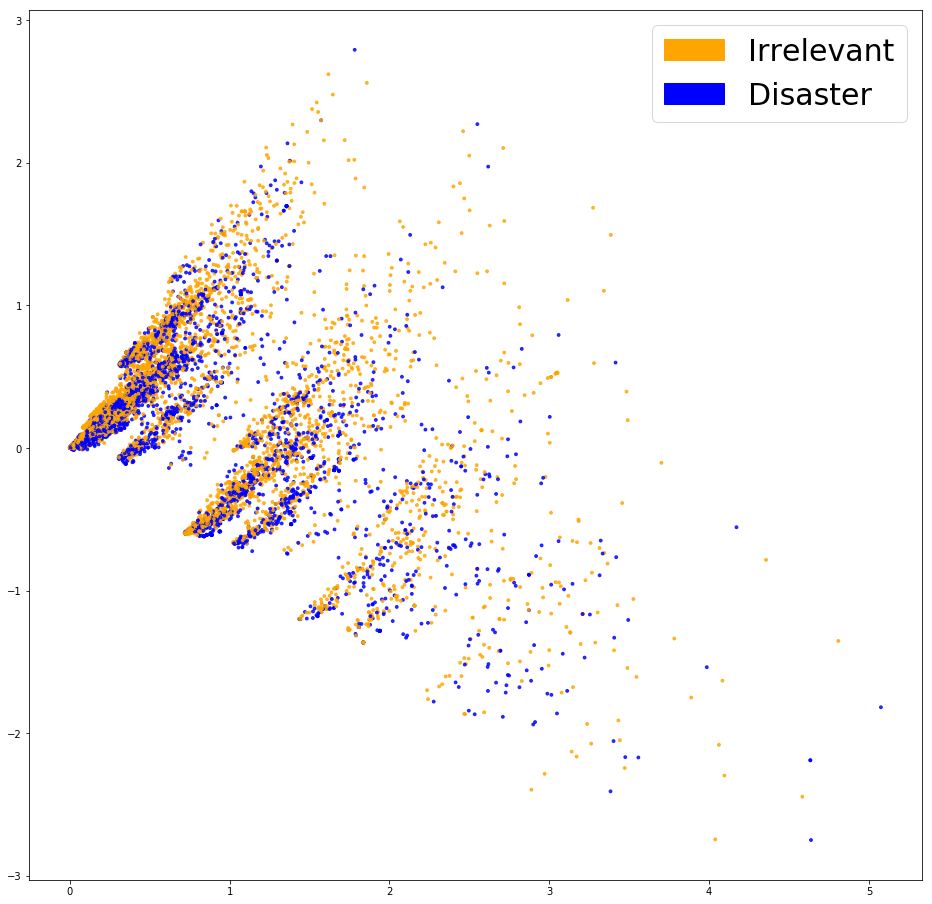

In [40]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

Honestly, this is a little depressing... I mean, I did most of my own stuff here, but then these magical vectorizers do all the work for you and now I'm just copying code like crazy.  Sigh.  I guess that's the idea. 

Oooooooh.  Maybe I can reconstruct things from my separately cleaned data to see if I do a bit better... 

In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [42]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.760, recall = 0.761, f1 = 0.760


In [43]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [50]:
# just playing with a sparse matrix from tfidf... what does it look like?

for row in range(20):
    print (row,X_train_tfidf[row,:])
#     if (X_train_tfidf[row,:].max())>2:
#        print (row,X_train_tfidf[row,:].max())



0   (0, 6364)	0.2532093326943942
  (0, 5440)	0.30874422814716146
  (0, 6203)	0.2829899898107953
  (0, 3092)	0.2913305457891839
  (0, 13102)	0.11068090631430708
  (0, 11474)	0.28191640761791625
  (0, 3575)	0.29403146393925467
  (0, 12047)	0.26990248983066817
  (0, 14050)	0.26110982998661336
  (0, 1928)	0.2526558907309076
  (0, 6048)	0.2926605402301968
  (0, 223)	0.2455531450907346
  (0, 10077)	0.29003910739136796
  (0, 1814)	0.2499873383687721
1   (0, 13102)	0.13107173171311987
  (0, 12860)	0.3679696483024547
  (0, 11439)	0.36122525396996874
  (0, 3035)	0.3847710321191115
  (0, 9257)	0.17140481285733752
  (0, 11140)	0.3633789922718792
  (0, 5245)	0.17043147276860152
  (0, 2665)	0.3268090586079953
  (0, 14255)	0.33913440573514403
  (0, 6792)	0.39572593175502613
2   (0, 5744)	0.30374919239609893
  (0, 6162)	0.19371009020462793
  (0, 1249)	0.14047458311664657
  (0, 3535)	0.2105258640059097
  (0, 7614)	0.2382101309078313
  (0, 13670)	0.2521999723484079
  (0, 12438)	0.27230175512571797
  (0,

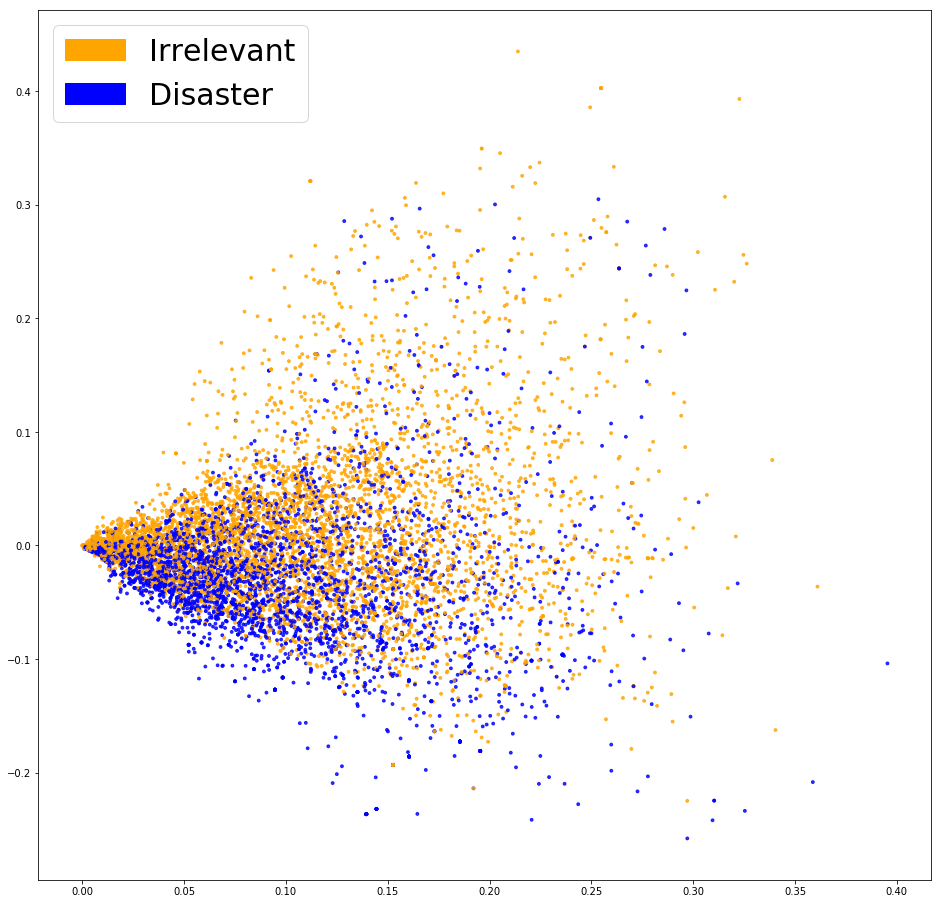

In [44]:


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()



In [45]:


clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)



In [46]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.769, precision = 0.767, recall = 0.769, f1 = 0.768
